# Double Logistic Selectivity (3-parameter formulation)

Parameterization, sensitivity, and prior elicitation via RTMB

## Overview

This notebook documents the 3-parameter double logistic selectivity curve used for prior elicitation in the EBS pollock assessment workflow. The formulation allows dome-shaped selectivity, where vulnerability increases with age to a peak and then declines. This behavior is motivated by gear avoidance at older ages, ontogenetic habitat shifts, or differential availability between age classes.

## Model definition

Let age be $a$, with parameters $p_1$, $p_2$, and $p_3$ and derived inflection points $\gamma_1$ and $\gamma_2$:

$$
\gamma_1 = p_1 + p_2, \qquad
\gamma_2 = 2p_1 + p_2 + p_3.
$$

The ascending limb is a standard logistic and the descending limb is one minus a logistic:

$$
\text{asc}(a) = \frac{1}{1 + \exp\left[-\log(19)\,\frac{a - \gamma_1}{p_1}\right]},
$$

$$
\text{desc}(a) = 1 - \frac{1}{1 + \exp\left[-\log(19)\,\frac{a - \gamma_2}{p_3}\right]}.
$$

The full double logistic selectivity is

$$
\text{sel}(a) = \min\left(1,\ \frac{\text{asc}(a)\,\text{desc}(a)}{0.95^2}\right).
$$

### Interpretation

-   $p_1 > 0$ controls the ascending slope and is the distance from $\gamma_1$ (50% selectivity) to the 95% point.
-   $p_2$ shifts the ascending limb through $\gamma_1 = p_1 + p_2$.
-   $p_3 > 0$ controls the descending slope and is the distance from $\gamma_2$ (50% on the descending limb) to the 5% point.
-   The dome width is $\gamma_2 - \gamma_1 = p_1 + p_3$.
-   The factor $0.95^{-2}$ normalizes the curve so that when both limbs are at 0.95 the product is near 1 (then capped at 1.0).

## Scenarios

In [ ]:
library(ggplot2)
library(dplyr)



Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

In [ ]:
knitr::kable(
  scenarios,
  digits = 2
)


  -----------------------------------------------------------------------------------
  scenario                               p1   p2    p3   gamma1   gamma2   dome_width
  ----------------------------------- ----- ---- ----- -------- -------- ------------
  Wide dome                             2.0    4   2.5      6.0     10.5          4.5

  Asymmetric                                                             

  (fast rise, slow decline)             0.8    4   3.0      4.8      8.6          3.8

  Asymmetric                                                             

  (slow rise, fast decline)             2.0    3   0.8      5.0      7.8          2.8

  Nearly asymptotic                     1.5    4   8.0      5.5     15.0          9.5
  -----------------------------------------------------------------------------------


The scenario summary in ([**tbl-dl-scenarios?**](#ref-tbl-dl-scenarios)) lists the four parameter sets and the derived inflection points ($\gamma_1$, $\gamma_2$) used in the selectivity scenarios.

## Faceted scenario curves

Each scenario appears on its own panel in ([**fig-dl-faceted?**](#ref-fig-dl-faceted)) so the ascent, descent, and dome width can be compared against the 50% and 95% reference lines.

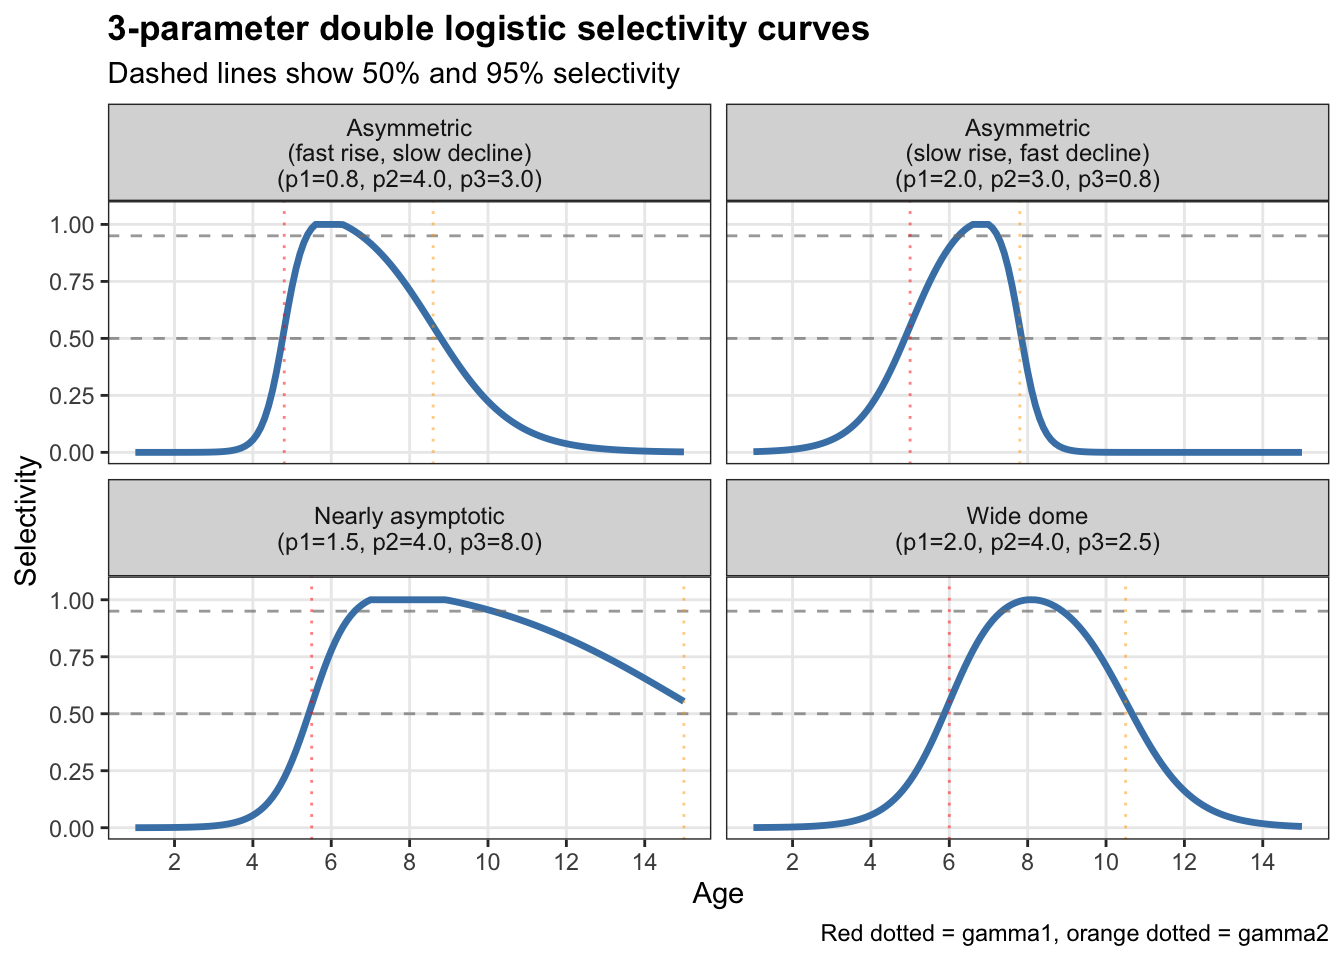

In [ ]:
p1_plot <- ggplot(sel_data, aes(x = age, y = selectivity)) +
  geom_line(linewidth = 1.2, color = "steelblue") +
  geom_hline(yintercept = c(0.5, 0.95), linetype = "dashed",
             color = "gray50", alpha = 0.7) +
  geom_vline(aes(xintercept = gamma1), linetype = "dotted",
             color = "red", alpha = 0.5) +
  geom_vline(aes(xintercept = gamma2), linetype = "dotted",
             color = "orange", alpha = 0.5) +
  facet_wrap(~label, ncol = 2) +
  scale_x_continuous(breaks = seq(2, 14, by = 2)) +
  scale_y_continuous(limits = c(0, 1.05), breaks = seq(0, 1, by = 0.25)) +
  labs(
    title = "3-parameter double logistic selectivity curves",
    subtitle = "Dashed lines show 50% and 95% selectivity",
    x = "Age",
    y = "Selectivity",
    caption = "Red dotted = gamma1, orange dotted = gamma2"
  ) +
  theme_bw(base_size = 11) +
  theme(
    strip.text = element_text(size = 9),
    plot.title = element_text(face = "bold"),
    panel.grid.minor = element_blank()
  )

p1_plot


## Overlay comparison

All scenarios are overlaid in ([**fig-dl-overlay?**](#ref-fig-dl-overlay)) to highlight differences in peak age and decline shape when the curves are viewed on a common axis.

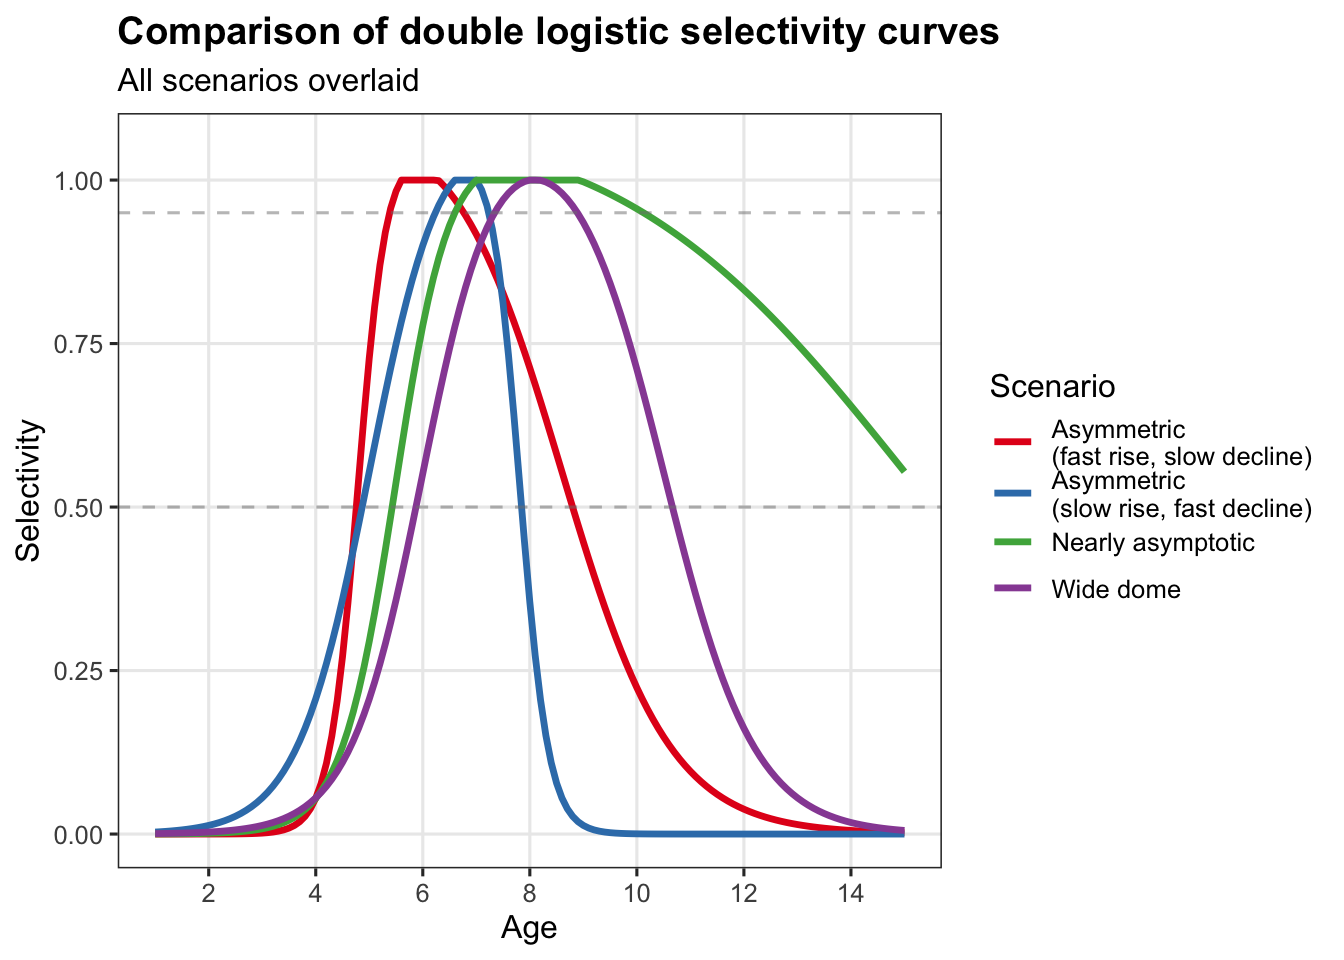

In [ ]:
p2_plot <- ggplot(sel_data, aes(x = age, y = selectivity, color = scenario)) +
  geom_line(linewidth = 1.2) +
  geom_hline(yintercept = c(0.5, 0.95), linetype = "dashed",
             color = "gray50", alpha = 0.5) +
  scale_x_continuous(breaks = seq(2, 14, by = 2)) +
  scale_y_continuous(limits = c(0, 1.05), breaks = seq(0, 1, by = 0.25)) +
  scale_color_brewer(palette = "Set1", name = "Scenario") +
  labs(
    title = "Comparison of double logistic selectivity curves",
    subtitle = "All scenarios overlaid",
    x = "Age",
    y = "Selectivity"
  ) +
  theme_bw(base_size = 12) +
  theme(
    legend.position = "right",
    plot.title = element_text(face = "bold"),
    panel.grid.minor = element_blank()
  )

p2_plot


## Parameter sensitivity analysis

The three panels in ([**fig-dl-sensitivity?**](#ref-fig-dl-sensitivity)) show how each parameter changes the curve when the other two are held fixed.

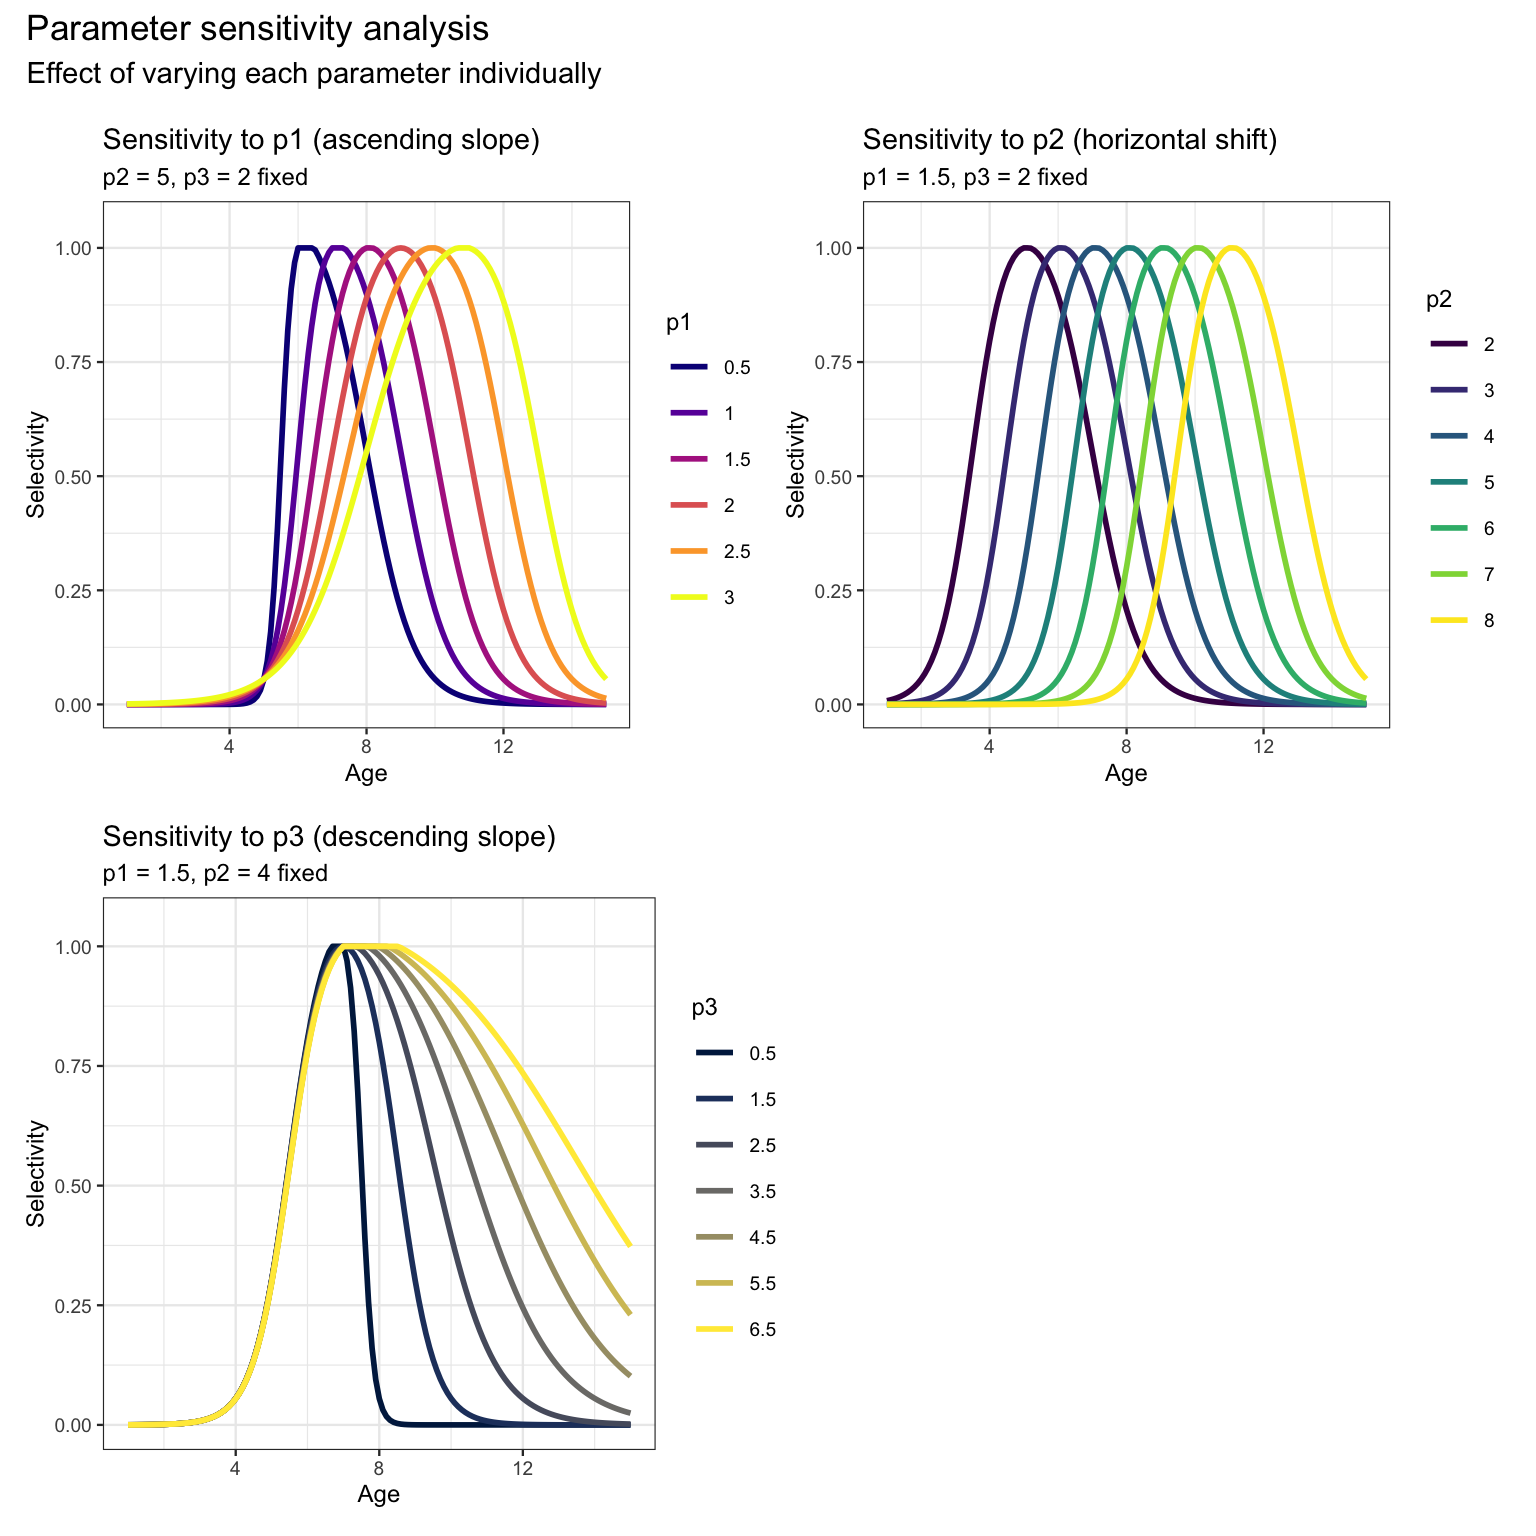

In [ ]:
p1_vary <- expand_grid(
  p1 = seq(0.5, 3, by = 0.5),
  p2 = 5,
  p3 = 2,
  age = ages
) %>%
  rowwise() %>%
  mutate(selectivity = dbl_logistic_sel(age, p1, p2, p3)) %>%
  ungroup()

p3a <- ggplot(p1_vary, aes(x = age, y = selectivity, color = factor(p1))) +
  geom_line(linewidth = 1) +
  scale_color_viridis_d(name = "p1", option = "C") +
  scale_y_continuous(limits = c(0, 1.05)) +
  labs(title = "Sensitivity to p1 (ascending slope)",
       subtitle = "p2 = 5, p3 = 2 fixed",
       x = "Age", y = "Selectivity") +
  theme_bw(base_size = 9) +
  theme(legend.position = "right", aspect.ratio = 1)

p2_vary <- expand_grid(
  p1 = 1.5,
  p2 = seq(2, 8, by = 1),
  p3 = 2,
  age = ages
) %>%
  rowwise() %>%
  mutate(selectivity = dbl_logistic_sel(age, p1, p2, p3)) %>%
  ungroup()

p3b <- ggplot(p2_vary, aes(x = age, y = selectivity, color = factor(p2))) +
  geom_line(linewidth = 1) +
  scale_color_viridis_d(name = "p2", option = "D") +
  scale_y_continuous(limits = c(0, 1.05)) +
  labs(title = "Sensitivity to p2 (horizontal shift)",
       subtitle = "p1 = 1.5, p3 = 2 fixed",
       x = "Age", y = "Selectivity") +
  theme_bw(base_size = 9) +
  theme(legend.position = "right", aspect.ratio = 1)

p3_vary <- expand_grid(
  p1 = 1.5,
  p2 = 4,
  p3 = seq(0.5, 6.5, by = 1),
  age = ages
) %>%
  rowwise() %>%
  mutate(selectivity = dbl_logistic_sel(age, p1, p2, p3)) %>%
  ungroup()

p3c <- ggplot(p3_vary, aes(x = age, y = selectivity, color = factor(p3))) +
  geom_line(linewidth = 1) +
  scale_color_viridis_d(name = "p3", option = "E") +
  scale_y_continuous(limits = c(0, 1.05)) +
  labs(title = "Sensitivity to p3 (descending slope)",
       subtitle = "p1 = 1.5, p2 = 4 fixed",
       x = "Age", y = "Selectivity") +
  theme_bw(base_size = 9) +
  theme(legend.position = "right", aspect.ratio = 1)

p_sensitivity <- (p3a | p3b) / (p3c | plot_spacer()) +
  plot_annotation(
    title = "Parameter sensitivity analysis",
    subtitle = "Effect of varying each parameter individually"
  )

p_sensitivity


## RTMB implementation with priors

A common approach is to estimate on the log scale for the positive parameters and apply lognormal priors on $p_1$ and $p_3$:

$$
\log(p_k) \sim \mathcal{N}(\mu_k, \sigma_k^2), \qquad k \in \{1, 3\}.
$$

If using a lognormal prior specified by median $m$ and coefficient of variation $\text{CV}$ on the natural scale, a convenient conversion is

$$
\mu = \log(m), \qquad \sigma = \sqrt{\log(\text{CV}^2 + 1)}.
$$

Parameter $p_2$ can remain unconstrained (normal prior) or be modeled on the log scale if you want to enforce $p_2 > 0$.

In [ ]:
library(RTMB)

dbl_logistic_sel <- function(age, p1, p2, p3) {
  gamma1 <- p1 + p2
  gamma2 <- 2 * p1 + p2 + p3
  asc <- 1 / (1 + exp(-log(19) * (age - gamma1) / p1))
  desc <- 1 - 1 / (1 + exp(-log(19) * (age - gamma2) / p3))
  (asc * desc * 0.95^(-2))
}

lognorm_from_median_cv <- function(median, cv) {
  sigma <- sqrt(log(cv^2 + 1))
  mu <- log(median)
  list(mu = mu, sigma = sigma)
}

age <- seq(1, 15, by = 0.25)
sel_obs <- c(
  0, 0, 0, 0, 0, 0, 0, 0.01, 0.01, 0.037142857, 0.064285714, 0.091428571,
  0.118571429, 0.145714286, 0.172857143, 0.2, 0.205882353, 0.211764706,
  0.217647059, 0.223529412, 0.229411765, 0.235294118, 0.241176471,
  0.247058824, 0.252941176, 0.258823529, 0.264705882, 0.270588235,
  0.276470588, 0.282352941, 0.288235294, 0.294117647, 0.3, 0.31, 0.32,
  0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43,
  0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.5125, 0.525, 0.5375, 0.55,
  0.5625, 0.575, 0.5875, 0.6, 0.6125, 0.625, 0.6375, 0.65, 0.6625,
  0.675, 0.6875, 0.7, 0.7125, 0.725, 0.7375, 0.75, 0.7625, 0.775,
  0.7875, 0.8, 0.807894737, 0.815789474, 0.823684211, 0.831578947,
  0.839473684, 0.847368421, 0.855263158, 0.863157895, 0.871052632,
  0.878947368, 0.886842105, 0.894736842, 0.902631579, 0.910526316,
  0.918421053, 0.926315789, 0.934210526, 0.942105263, 0.95, 0.954545455,
  0.959090909, 0.963636364, 0.968181818, 0.972727273, 0.977272727,
  0.981818182, 0.986363636, 0.990909091, 0.995454545, 1, 1, 1, 1, 1, 1,
  1, 0.989285714, 0.978571429, 0.967857143, 0.957142857, 0.946428571,
  0.935714286, 0.925, 0.914285714, 0.903571429, 0.892857143, 0.882142857,
  0.871428571, 0.860714286, 0.85, 0.839285714, 0.828571429, 0.817857143,
  0.807142857, 0.796428571, 0.785714286, 0.775, 0.764285714, 0.753571429,
  0.742857143, 0.732142857, 0.721428571, 0.710714286, 0.7
)
sel_sd <- rep(0.05, length(age))

p1_prior <- lognorm_from_median_cv(median = 1.5, cv = 0.4)
p3_prior <- lognorm_from_median_cv(median = 2.5, cv = 0.6)
p2_prior <- list(mu = 4, sigma = 1)

make_prior_data <- function(p1_prior, p2_prior, p3_prior) {
  list(
    age = age,
    sel_obs = sel_obs,
    sel_sd = sel_sd,
    mu_log_p1 = p1_prior$mu,
    sd_log_p1 = p1_prior$sigma,
    mu_p2 = p2_prior$mu,
    sd_p2 = p2_prior$sigma,
    mu_log_p3 = p3_prior$mu,
    sd_log_p3 = p3_prior$sigma
  )
}

data <- make_prior_data(p1_prior, p2_prior, p3_prior)

parameters <- list(
  log_p1 = log(1.5),
  p2 = 4,
  log_p3 = log(2.5)
)

make_obj <- function(data, parameters) {
  f <- function(parms) {
    getAll(data, parms, warn = FALSE)
    p1 <- exp(log_p1)
    p3 <- exp(log_p3)
    sel_hat <- dbl_logistic_sel(age, p1, p2, p3)

    nll <- 0
    nll <- nll - dnorm(log_p1, mu_log_p1, sd_log_p1, log = TRUE)
    nll <- nll - dnorm(p2, mu_p2, sd_p2, log = TRUE)
    nll <- nll - dnorm(log_p3, mu_log_p3, sd_log_p3, log = TRUE)

    ADREPORT(c(p1 = p1, p2 = p2, p3 = p3))
    nll
  }

  MakeADFun(f, parameters)
}

obj <- make_obj(data, parameters)
opt <- nlminb(obj$par, obj$fn, obj$gr)


outer mgc:  0 

outer mgc:  0 
outer mgc:  0.006737636 
outer mgc:  0.006737636 
outer mgc:  0.001 
outer mgc:  0.001 
outer mgc:  0.003252194 
outer mgc:  0.003252194 
outer mgc:  2.5 

## MCMC evaluation

In [ ]:
library(SparseNUTS)


Loading required package: StanEstimators

Optimizing...

Rebuilding RTMB obj without random effects...

diag metric selected b/c low correlations (max=0)

log-posterior at inits=(-1.21); at conditional mode=-1.213

Starting MCMC sampling...



Gradient evaluation took 3.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.018 seconds (Warm-up)
               0.197 seconds (Sampling)
               0.215 seconds (Total)



Model 'selectivity_set1' has 3 pars, and was fit using NUTS with a 'diag' metric
1 chain(s) of 1300 total iterations (150 warmup) were used
Average run time per chain was 0.22 seconds 
Minimum ESS=360.7 (31.37%), and maximum Rhat=1.015
There were 0 divergences after warmup

In [ ]:
mcmc_selectivity_df <- function(fit, age) {
  p1 <- exp(fit$samples[, , 1])
  p2 <- fit$samples[, , 2]
  p3 <- exp(fit$samples[, , 3])

  tibble(p1, p2, p3) %>%
    mutate(set = factor(row_number())) %>%
    crossing(age = age) %>%
    mutate(sel = dbl_logistic_sel(age, p1, p2, p3)) %>%
    mutate(age = as.numeric(age)) %>%
    arrange(set, age)
}

plot_mcmc_selectivity <- function(df, alpha = 0.1) {
  ggplot(df, aes(age, sel, group = set)) +
    geom_line(alpha = alpha) +
    ggthemes::theme_few()
}


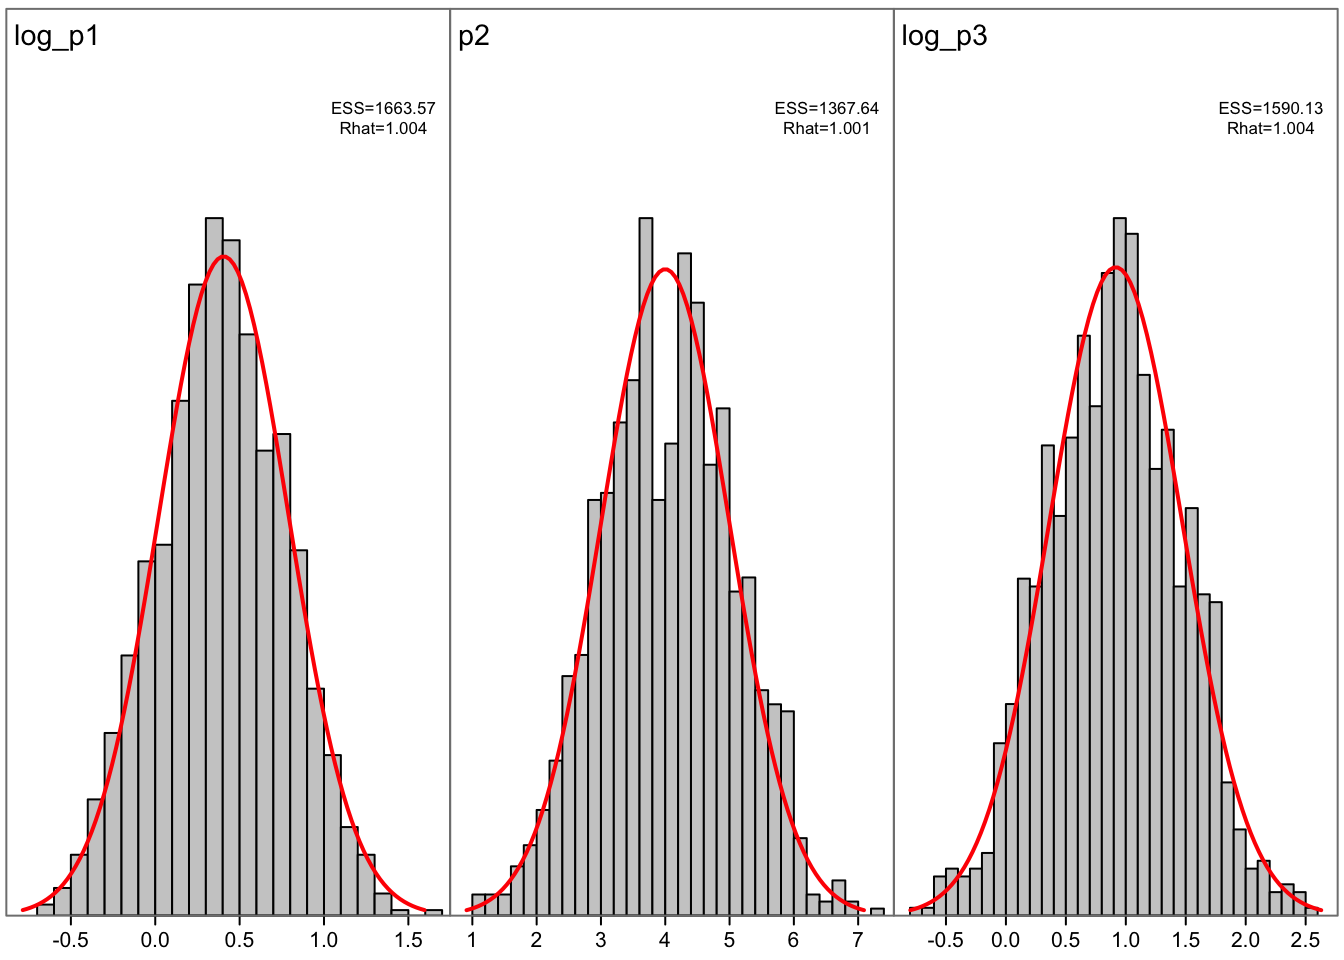

In [ ]:
SparseNUTS::plot_marginals(fit_set1, pars = 1:3)


The marginal posterior densities in ([**fig-dl-marginals?**](#ref-fig-dl-marginals)) summarize $(p_1, p_2,
p_3)$ under prior set 1.

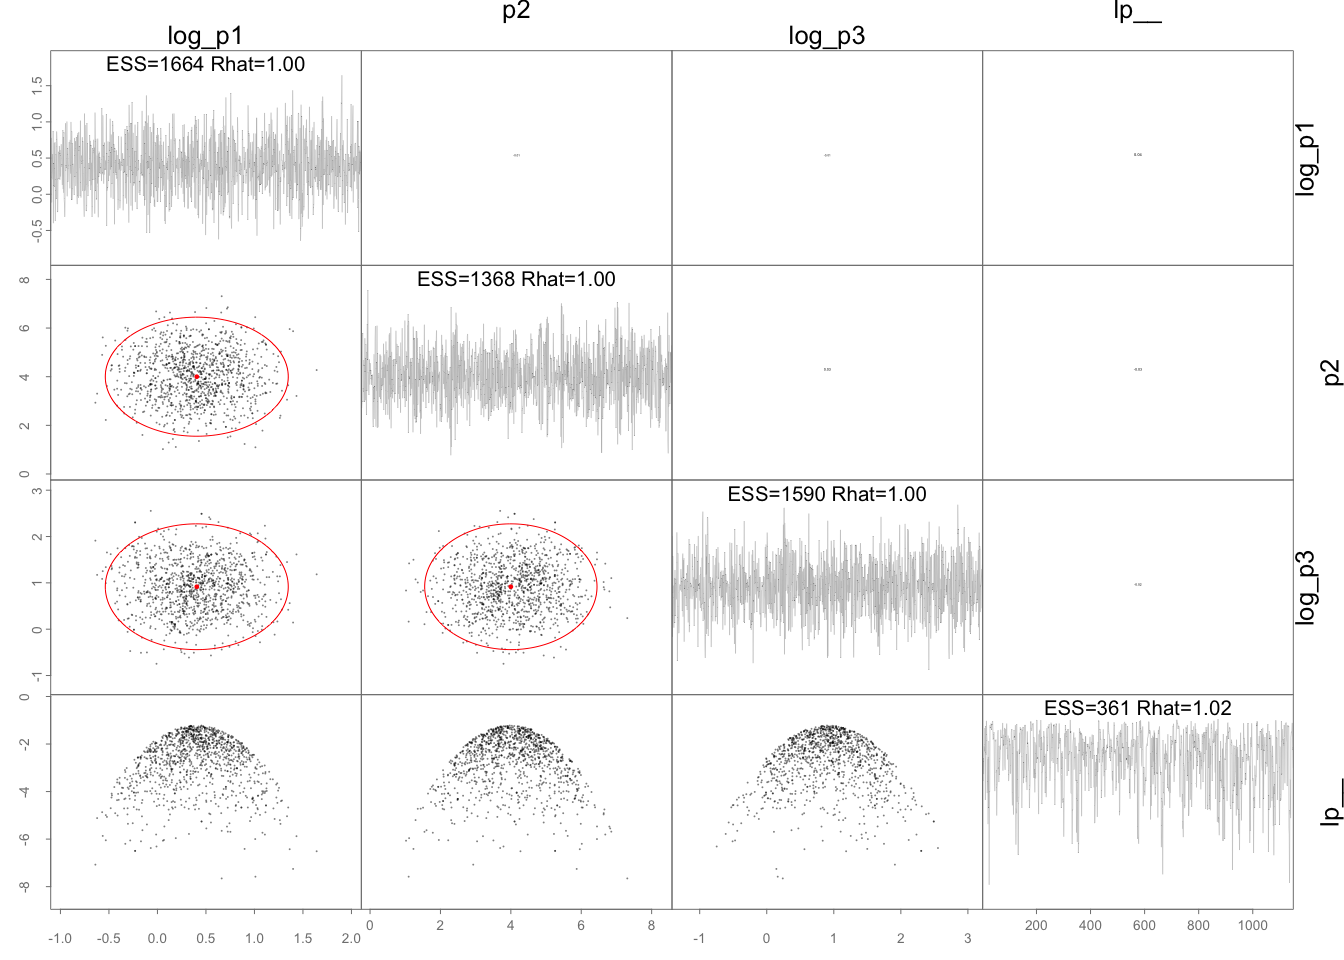

In [ ]:
pairs(fit_set1)


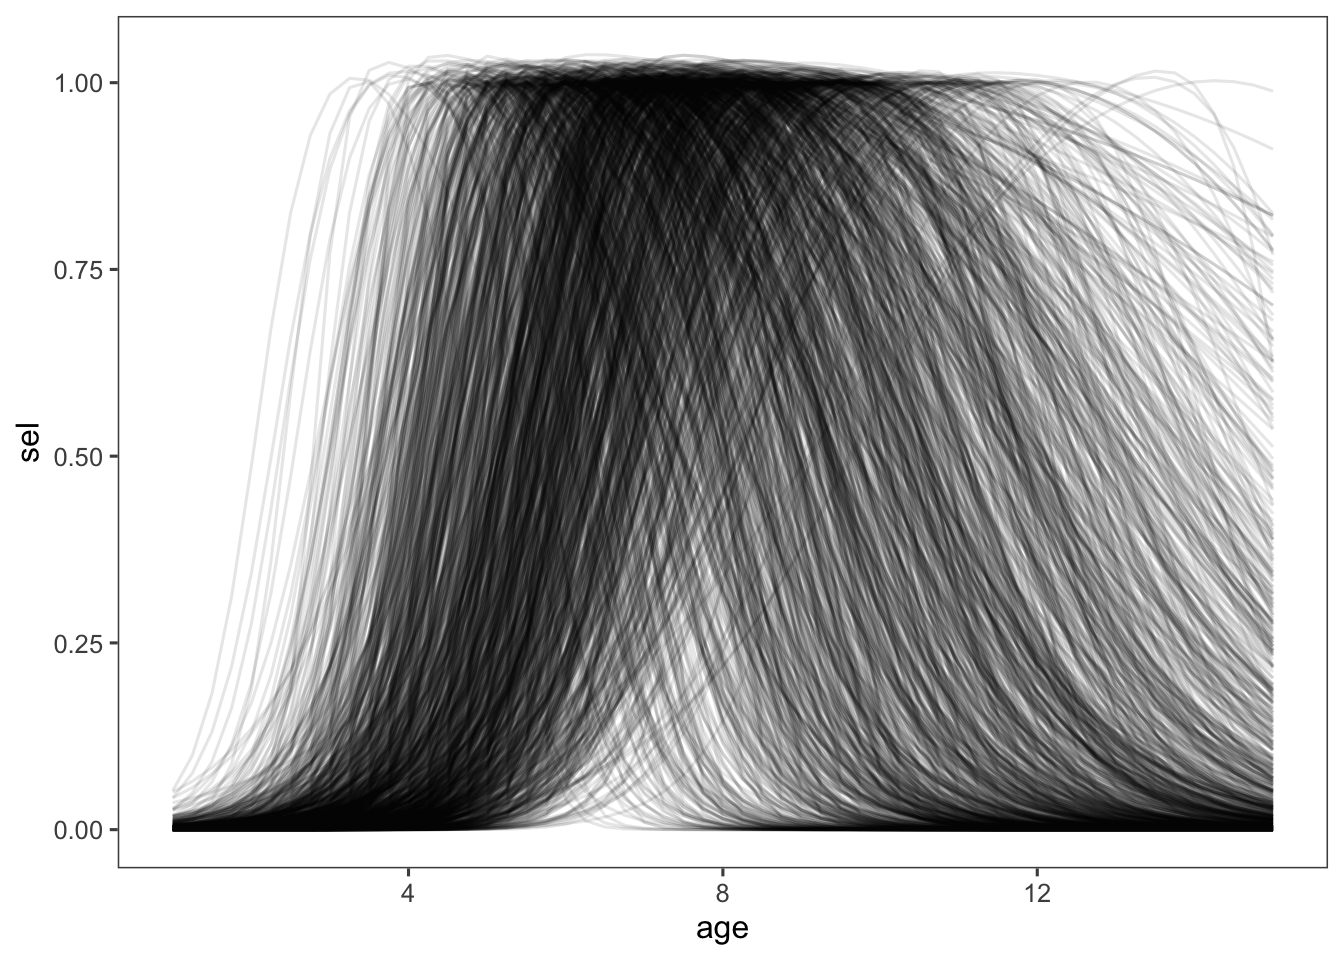

In [ ]:
df_set1 <- mcmc_selectivity_df(fit_set1, age)
plot_mcmc_selectivity(df_set1)


### Additional prior sets

In [ ]:
p1_prior_set2 <- lognorm_from_median_cv(median = 1.5, cv = 0.4)
p3_prior_set2 <- lognorm_from_median_cv(median = 8, cv = 0.6)
p2_prior_set2 <- list(mu = 4, sigma = 1)
data_set2 <- make_prior_data(p1_prior_set2, p2_prior_set2, p3_prior_set2)
obj_set2 <- make_obj(data_set2, parameters)
fit_set2 <- run_snuts(obj_set2, data_set2, seed = 2, model_name = "selectivity_set2")


Optimizing...

Rebuilding RTMB obj without random effects...

diag metric selected b/c low correlations (max=0)

log-posterior at inits=(-1.21); at conditional mode=-1.213

Starting MCMC sampling...



Gradient evaluation took 2.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.018 seconds (Warm-up)
               0.116 seconds (Sampling)
               0.134 seconds (Total)



Model 'selectivity_set2' has 3 pars, and was fit using NUTS with a 'diag' metric
1 chain(s) of 1300 total iterations (150 warmup) were used
Average run time per chain was 0.13 seconds 
Minimum ESS=393.8 (34.24%), and maximum Rhat=1.003
There were 0 divergences after warmup

Optimizing...

Rebuilding RTMB obj without random effects...

diag metric selected b/c low correlations (max=0)

log-posterior at inits=(-1.91); at conditional mode=-1.906

Starting MCMC sampling...



Gradient evaluation took 2.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.017 seconds (Warm-up)
               0.121 seconds (Sampling)
               0.138 seconds (Total)



Model 'selectivity_set3' has 3 pars, and was fit using NUTS with a 'diag' metric
1 chain(s) of 1300 total iterations (150 warmup) were used
Average run time per chain was 0.14 seconds 
Minimum ESS=427 (37.13%), and maximum Rhat=1.005
There were 0 divergences after warmup

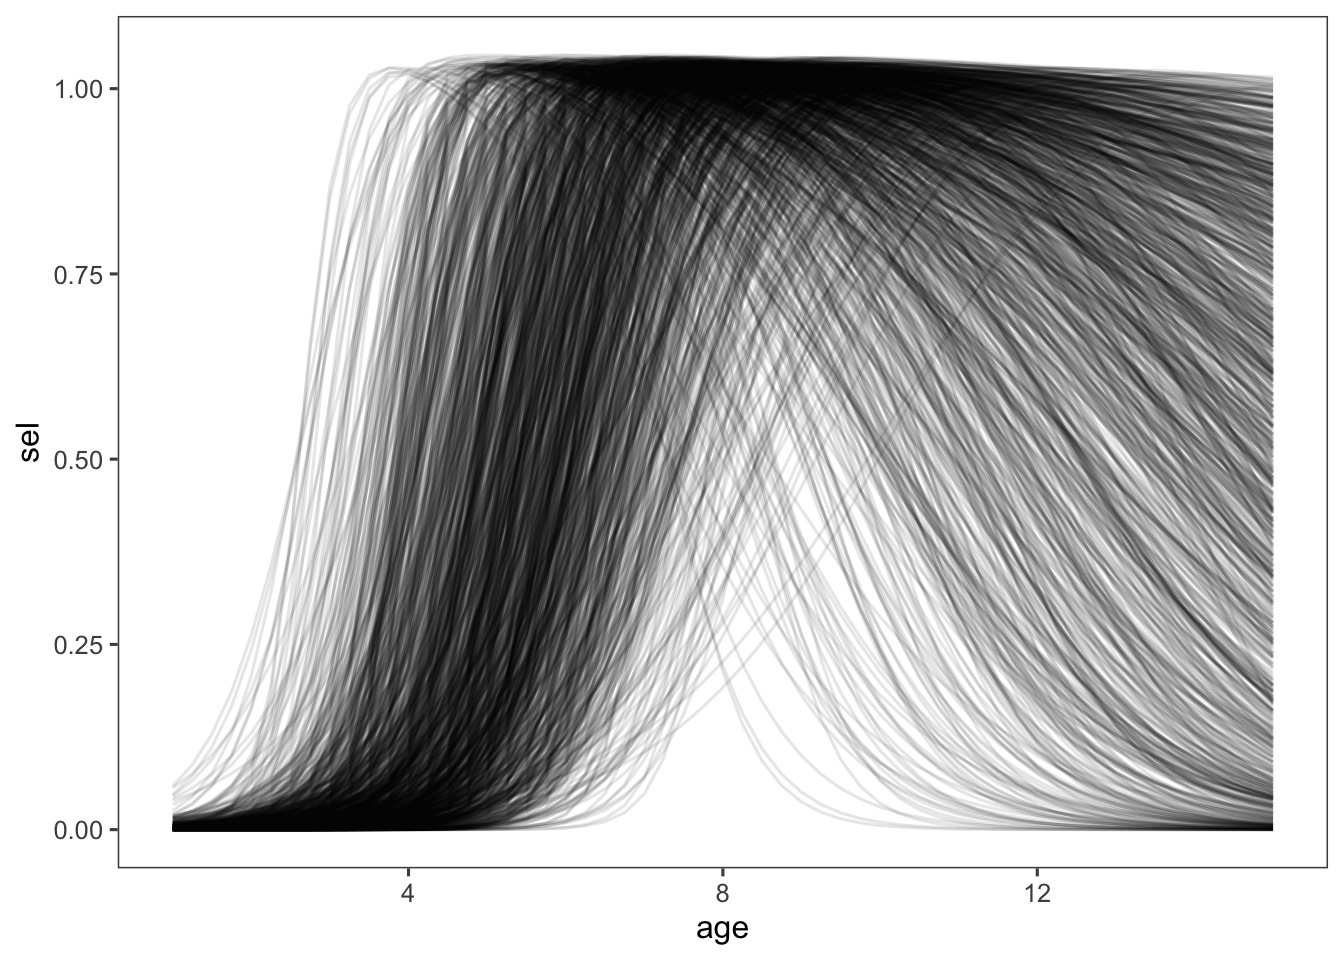

In [ ]:
df_set2 <- mcmc_selectivity_df(fit_set2, age)
plot_mcmc_selectivity(df_set2)


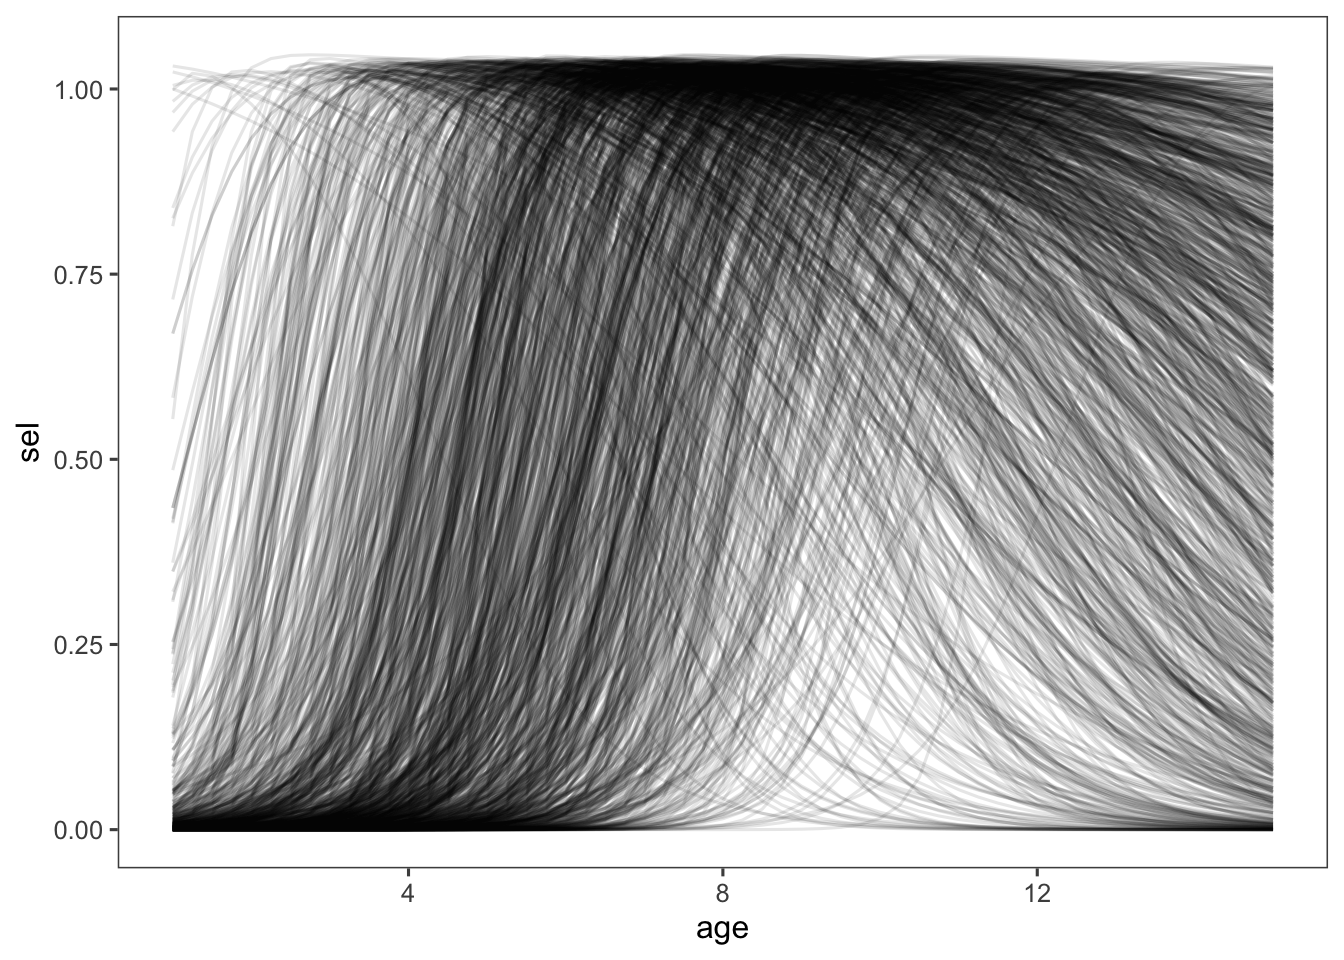

In [ ]:
df_set3 <- mcmc_selectivity_df(fit_set3, age)
plot_mcmc_selectivity(df_set3)
